<a href="https://colab.research.google.com/github/trancenoid/GANs/blob/master/audioGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir './tracks'


In [0]:
!cp './drive/My Drive/audioGAN_data/piano/A_h3kt6Dp9M' ./tracks/
!cp './drive/My Drive/audioGAN_data/piano/ET15VTJN-e0' ./tracks/
!cp './drive/My Drive/audioGAN_data/piano/pj1jHGU4a4g' ./tracks/
!cp './drive/My Drive/audioGAN_data/piano/3hr' ./tracks/

In [0]:
!cp ./tracks/A_h3kt6Dp9M './drive/My Drive/audioGAN_data/piano'
!cp ./tracks/ET15VTJN-e0 './drive/My Drive/audioGAN_data/piano'
!cp ./tracks/pj1jHGU4a4g './drive/My Drive/audioGAN_data/piano'

In [3]:
% pylab inline
import librosa
from librosa.display import waveplot,specshow
import os
import IPython.display as ipd
import pandas as pd
import glob 
from librosa.core import stft, istft
import keras
from keras.layers import *
from keras import initializers
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.models import Model, Sequential
from tqdm import tqdm
import numpy as np
import re


Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


In [8]:
print(os.listdir('./tracks'))
#!rmdir './tracks/.ipynb_checkpoints'

['A_h3kt6Dp9M', 'ET15VTJN-e0', '3hr', 'pj1jHGU4a4g']


In [5]:

#tracks = os.listdir('./drive/My Drive/audioGAN_data')
tracks = os.listdir('./tracks')
sr = 8191
clip_len = 8
#data, sampling_rate = librosa.load('016 - Timbaland ft. Keri Hilson - The Way I Are.MP3', sr = 8192)
def load_data():
  nt = len(tracks)
  X = []
  for track in tqdm(tracks):
    #data, _ = librosa.load('./drive/My Drive/audioGAN_data/' + track, sr = sr)
    data, _ = librosa.load('./tracks/' + track, sr = sr)
    data = [ np.array(stft(data[(i*clip_len*sr):((i+1)*clip_len*sr)]))[0:-1, :] for i in tqdm(range( int(len(data)/(clip_len*sr)) - 1 ))]
    X.extend(data)
  data = np.array(X)
  print(data.shape)
  X = np.zeros(data.shape)
  Y = np.zeros(data.shape)
  for i in tqdm(range(data.shape[0])):
    for j in range(data.shape[1]):
      for k in range(data.shape[2]):
        #Y[i,j,k] = re.findall( '(-*[0-9]+\.[0-9]+)(?:[\+|\-])([0-9]+)', X[i,j,k])[0][0]
        temp = re.findall( '(-?[0-9]+\.?[0-9]+(e[\+|\-][0-9]+)?)?([\+|\-]?[0-9]+\.?[0-9]*(e[\+|\-][0-9]+)?)j',
                          str(data[i,j,k]))
        try:
          if(temp[0][0] != ''):
            X[i,j,k] = float(temp[0][0])
          else:
            X[i,j,k] = 0.0
          Y[i,j,k] = float(temp[0][2])
        except IndexError as e:
          print(data[i,j,k])
  np.save('./X', X)
  np.save('./Y', Y)
  !mv './X.npy' './drive/My Drive/audioGAN_data/piano/'
  !mv './Y.npy' './drive/My Drive/audioGAN_data/piano/'
#X = np.array(load_data()).transpose([1,2,3,0])
load_data()

100%|██████████| 4/4 [21:36<00:00, 329.93s/it]


(3033, 1024, 128)


100%|██████████| 3033/3033 [28:45<00:00,  1.74it/s]


In [0]:
!cp './drive/My Drive/audioGAN_data/piano/X.npy' './X.npy'
!cp './drive/My Drive/audioGAN_data/piano/Y.npy' './Y.npy'

In [0]:
!mv './data.npy' './drive/My Drive/audioGAN_data/piano/'

In [0]:
X = np.load('X.npy', mmap_mode = 'r')
Y = np.load('Y.npy', mmap_mode = 'r')

In [8]:
X = np.stack([X,Y]).transpose([1,2,3,0])
print(X.shape)
np.save('./X', X)

(3033, 1024, 128, 2)


In [0]:
np.save('./X', X)


In [0]:
!cp './X.npy' './drive/My Drive/audioGAN_data/piano/train'

In [0]:
!cp './drive/My Drive/audioGAN_data/piano/train' './data.npy'
X = np.load('data.npy', mmap_mode = 'r')


In [0]:
X.shape

(3041, 1024, 128, 2)

In [5]:
adam = Adam(lr = 0.0002, beta_1 = 0.5)
inShape = 100

def build_gen():
  
  G = Sequential()
  G.add(Dense(128*64*64, input_shape = (100,), activation = 'relu'))
  G.add(Reshape([128,64,64,]))
  G.add(Conv2DTranspose(32,(5,5), strides = (1,2), padding = 'same'))
  G.add(LeakyReLU(0.1))
  G.add(Conv2DTranspose(16,(5,5), strides = (1,2), padding = 'same'))
  G.add(LeakyReLU(0.1))
  G.add(Conv2DTranspose(8,(5,5), strides = (1,2), padding = 'same'))
  G.add(LeakyReLU(0.1))
  G.add(Conv2DTranspose(2,(5,5), strides = (1,2), padding = 'same'))
  G.add(LeakyReLU(0.1))
  G.add(Reshape([128,1024*2]))
  G.add(LSTM(2048 , activation = 'tanh', return_sequences = True))
  G.add(LeakyReLU(0.1))
  G.add(Reshape([128,1024,2]))
  
  return G  
    

def build_dis():
  D = Sequential()
  D.add(Reshape([128,1024*2], input_shape = [128,1024,2]))
  D.add(LSTM(256 , activation = 'tanh'))
  D.add(LeakyReLU(0.1))
  D.add(Dense(128, activation = 'relu'))
  D.add(LeakyReLU(0.1))
  D.add(Dense(64, activation = 'relu'))
  D.add(LeakyReLU(0.1))
  D.add(Dense(1, activation = 'sigmoid'))
  D.compile(loss = 'binary_crossentropy', optimizer = adam)
  
  return D

D = build_dis()
G = build_gen()

D.trainable = False
ganIn = Input(shape = (inShape,))
genOut = G(ganIn)
ganOut = D(genOut)
GAN = Model(inputs = ganIn, outputs = ganOut)
GAN.compile(loss = 'binary_crossentropy', optimizer = adam)

W0715 08:28:13.376059 140627268036480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0715 08:28:13.378678 140627268036480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0715 08:28:13.405279 140627268036480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0715 08:28:13.901111 140627268036480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0715 08:28:13.910848 140627268036480 deprecation_wrappe

In [0]:
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 524288)            52953088  
_________________________________________________________________
reshape_16 (Reshape)         (None, 128, 64, 64)       0         
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 128, 128, 32)      51232     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_transpose_18 (Conv2DT (None, 128, 256, 16)      12816     
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 128, 256, 16)      0         
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 128, 512, 8)       3208      
__________

In [0]:
#X = np.load('data.npy', mmap_mode = 'r')
sr = 8191
dLosses = []
gLosses = []
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('dcgan_loss_epoch_%d.png' % epoch)
    
def generate_noise(n_samples, noise_dim):
  X = np.random.normal(0, 1, size=(n_samples, noise_dim))
  return X

def play_clips(batchidx):
  noise = generate_noise(5, 100)
  pred = G.predict(noise)
  ans = np.zeros((pred.shape[0], pred.shape[1], pred.shape[2]), dtype = complex)
  for i in range(pred.shape[0]):
    for j in range(pred.shape[1]):
      for k in range(pred.shape[2]):
        if(str(pred[i,j,k,1])[0] != '-'):
          ans[i,j,k] = complex(str(pred[i,j,k,0]) + '+' + str(pred[i,j,k,1]) + 'j')
        else:
          ans[i,j,k] = complex(str(pred[i,j,k,0]) + str(pred[i,j,k,1]) + 'j')

  for i in range(1):
    ipd.Audio(data = istft(ans[i]), rate = sr)
    
def loadWeights(epoch):
  G.load_weights('./drive/My Drive/audio_model/G_epoch_%d.h5' % epoch)
  D.load_weights('./drive/My Drive/audio_model/D_epoch_%d.h5' % epoch)

def saveModels(epoch):
  G.save('./drive/My Drive/audio_model/G_epoch_%d.h5' % epoch)
  D.save('./drive/My Drive/audio_model/D_epoch_%d.h5' % epoch)

In [0]:


def train(epochs=1, BATCH_SIZE=16, resume_at = 0):
  if (resume_at != 0) : 
    loadWeights(resume_at)
    start = resume_at
  else:
    start = 0
  num_batches = int(X.shape[0]/BATCH_SIZE)
  N_EPOCHS = epochs
  for epoch in range(start, start + N_EPOCHS):

    cum_d_loss = 0.
    cum_g_loss = 0.

    for batch_idx in tqdm(range(num_batches)):
      clips = X[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE].transpose([0,2,1,3])

      noise_data = generate_noise(BATCH_SIZE, 100)
      generated_clips = G.predict(noise_data)
      noise_prop = 0.05

      true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
      #flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
      #true_labels[flipped_idx] = 1 - true_labels[flipped_idx]
      D.trainable = True 

      d_loss_true = D.train_on_batch(clips, true_labels)
      gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
      #flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
      #gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]
      
    
      d_loss_gene = D.train_on_batch(generated_clips, gene_labels)
      #d_loss_gene, d_loss_true = (0,0)
      D.trainable = False
      d_loss = 0.5 * np.add(d_loss_true, d_loss_gene)
      cum_d_loss += d_loss

      noise_data = generate_noise(BATCH_SIZE, 100)
      g_loss = GAN.train_on_batch(noise_data, np.zeros((BATCH_SIZE, 1)))
      cum_g_loss += g_loss
    print('  Epoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))
    if( (epoch+1)%5 == 0): 
      play_clips("epoch" + str(epoch))
      saveModels(epoch)

if __name__ == '__main__':
  train(600, 32, resume_at = 409)


100%|██████████| 94/94 [05:14<00:00,  3.33s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 412, Generator Loss: 2.9994623204495046, Discriminator Loss: 0.19831112407623452



100%|██████████| 94/94 [05:13<00:00,  3.33s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 413, Generator Loss: 2.997914542543127, Discriminator Loss: 0.19891289526477773



100%|██████████| 94/94 [05:13<00:00,  3.33s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 414, Generator Loss: 3.000667511148656, Discriminator Loss: 0.1981235959745468



100%|██████████| 94/94 [05:13<00:00,  3.33s/it]


  Epoch: 415, Generator Loss: 2.994116369714128, Discriminator Loss: 0.1971037045438239



100%|██████████| 94/94 [05:15<00:00,  3.34s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 416, Generator Loss: 2.9836469102413097, Discriminator Loss: 0.1991957407048408



100%|██████████| 94/94 [05:13<00:00,  3.34s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 417, Generator Loss: 2.978720599032463, Discriminator Loss: 0.1995089237994336



100%|██████████| 94/94 [05:13<00:00,  3.34s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 418, Generator Loss: 2.998150554109127, Discriminator Loss: 0.1976115327883274



100%|██████████| 94/94 [05:13<00:00,  3.33s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 419, Generator Loss: 2.988277054847555, Discriminator Loss: 0.19805105189059644



100%|██████████| 94/94 [05:13<00:00,  3.34s/it]


  Epoch: 420, Generator Loss: 2.988005001494225, Discriminator Loss: 0.19946854165259828



100%|██████████| 94/94 [05:14<00:00,  3.34s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 421, Generator Loss: 2.995108152957673, Discriminator Loss: 0.1982222630622539



100%|██████████| 94/94 [05:13<00:00,  3.34s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 422, Generator Loss: 3.007889430573646, Discriminator Loss: 0.1971053011873935



100%|██████████| 94/94 [05:13<00:00,  3.33s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 423, Generator Loss: 3.0053913415746485, Discriminator Loss: 0.1980914777897774



100%|██████████| 94/94 [05:13<00:00,  3.32s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 424, Generator Loss: 2.9990135380562317, Discriminator Loss: 0.19849618873063554



100%|██████████| 94/94 [05:12<00:00,  3.33s/it]


  Epoch: 425, Generator Loss: 3.0028527087353645, Discriminator Loss: 0.19841487087467882



100%|██████████| 94/94 [05:14<00:00,  3.33s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 426, Generator Loss: 2.996186763682264, Discriminator Loss: 0.19843505338785497



100%|██████████| 94/94 [05:13<00:00,  3.33s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 427, Generator Loss: 3.007318263358258, Discriminator Loss: 0.19822532604349422



100%|██████████| 94/94 [05:12<00:00,  3.32s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 428, Generator Loss: 3.002410409298349, Discriminator Loss: 0.1971844582164541



100%|██████████| 94/94 [05:12<00:00,  3.32s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 429, Generator Loss: 3.001629261260337, Discriminator Loss: 0.1983882968730115



100%|██████████| 94/94 [05:13<00:00,  3.33s/it]


  Epoch: 430, Generator Loss: 2.9889798164367676, Discriminator Loss: 0.19833912890642247



100%|██████████| 94/94 [05:14<00:00,  3.33s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 431, Generator Loss: 2.9749530477726713, Discriminator Loss: 0.20063672389121764



100%|██████████| 94/94 [05:13<00:00,  3.34s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 432, Generator Loss: 2.986358404159546, Discriminator Loss: 0.19994444606151987



100%|██████████| 94/94 [05:13<00:00,  3.32s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 433, Generator Loss: 2.992934802745251, Discriminator Loss: 0.19847315153542985



100%|██████████| 94/94 [05:09<00:00,  3.29s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 434, Generator Loss: 3.0176793742687145, Discriminator Loss: 0.19798026202206917



100%|██████████| 94/94 [05:09<00:00,  3.29s/it]


  Epoch: 435, Generator Loss: 2.9913666425867285, Discriminator Loss: 0.198254738082277



100%|██████████| 94/94 [05:10<00:00,  3.29s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 436, Generator Loss: 2.9840087662351893, Discriminator Loss: 0.19898725285174998



100%|██████████| 94/94 [05:09<00:00,  3.28s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 437, Generator Loss: 3.007899953963909, Discriminator Loss: 0.19849368549407798



100%|██████████| 94/94 [05:14<00:00,  4.06s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 438, Generator Loss: 3.002470407080143, Discriminator Loss: 0.19710918072056263



100%|██████████| 94/94 [05:26<00:00,  3.61s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 439, Generator Loss: 3.006359759797441, Discriminator Loss: 0.1990219178668996



100%|██████████| 94/94 [05:17<00:00,  3.32s/it]


  Epoch: 440, Generator Loss: 3.0229353651087334, Discriminator Loss: 0.19597787092974844



100%|██████████| 94/94 [05:13<00:00,  3.31s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 441, Generator Loss: 2.9919408838799657, Discriminator Loss: 0.1984378048714171



100%|██████████| 94/94 [05:11<00:00,  3.31s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 442, Generator Loss: 2.9911611638170608, Discriminator Loss: 0.19904087547292101



100%|██████████| 94/94 [05:11<00:00,  3.32s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 443, Generator Loss: 3.00169127799095, Discriminator Loss: 0.19880477418290807



100%|██████████| 94/94 [05:11<00:00,  3.31s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 444, Generator Loss: 2.9902546583337988, Discriminator Loss: 0.19993474540558268



100%|██████████| 94/94 [05:10<00:00,  3.30s/it]


  Epoch: 445, Generator Loss: 2.993909090123278, Discriminator Loss: 0.1987903527122863



100%|██████████| 94/94 [05:12<00:00,  3.29s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 446, Generator Loss: 2.993912732347529, Discriminator Loss: 0.19808473533138315



100%|██████████| 94/94 [05:10<00:00,  3.30s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 447, Generator Loss: 2.9879671360584017, Discriminator Loss: 0.19928369338208057



100%|██████████| 94/94 [05:10<00:00,  3.30s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 448, Generator Loss: 2.996378700783912, Discriminator Loss: 0.20024529242135108



100%|██████████| 94/94 [05:10<00:00,  3.31s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 449, Generator Loss: 2.9954952940027764, Discriminator Loss: 0.19834398557531072



100%|██████████| 94/94 [05:10<00:00,  3.30s/it]


  Epoch: 450, Generator Loss: 2.9789539524849427, Discriminator Loss: 0.1999730924342541



100%|██████████| 94/94 [05:35<00:00,  3.65s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 451, Generator Loss: 2.98600483955221, Discriminator Loss: 0.19924251164527648



100%|██████████| 94/94 [05:19<00:00,  3.30s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 452, Generator Loss: 3.0093334532798606, Discriminator Loss: 0.19879762733236273



100%|██████████| 94/94 [05:11<00:00,  3.31s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 453, Generator Loss: 3.0013133236702454, Discriminator Loss: 0.19795753553192666



100%|██████████| 94/94 [05:11<00:00,  3.32s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 454, Generator Loss: 3.008608691235806, Discriminator Loss: 0.19788740464347473



100%|██████████| 94/94 [05:11<00:00,  3.30s/it]


  Epoch: 455, Generator Loss: 3.0013447847772152, Discriminator Loss: 0.19819277493243523



100%|██████████| 94/94 [05:28<00:00,  3.60s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 456, Generator Loss: 3.000827822279423, Discriminator Loss: 0.1972518244639356



100%|██████████| 94/94 [05:11<00:00,  3.32s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 457, Generator Loss: 2.987328166657306, Discriminator Loss: 0.19895511088853188



100%|██████████| 94/94 [05:11<00:00,  3.31s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 458, Generator Loss: 2.996806028041434, Discriminator Loss: 0.19816507145445397



100%|██████████| 94/94 [05:11<00:00,  3.31s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 459, Generator Loss: 3.005001167033581, Discriminator Loss: 0.19682240137394438



100%|██████████| 94/94 [05:11<00:00,  3.30s/it]


  Epoch: 460, Generator Loss: 3.0062713775228946, Discriminator Loss: 0.19687328677862248



100%|██████████| 94/94 [05:18<00:00,  3.35s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 461, Generator Loss: 3.0011486017957645, Discriminator Loss: 0.19717740806493353



100%|██████████| 94/94 [05:11<00:00,  3.31s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 462, Generator Loss: 2.9775601929806648, Discriminator Loss: 0.2023569258286598



100%|██████████| 94/94 [05:11<00:00,  3.31s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 463, Generator Loss: 2.9844573305008257, Discriminator Loss: 0.19966164104481962



100%|██████████| 94/94 [05:10<00:00,  3.31s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 464, Generator Loss: 3.0025513933060015, Discriminator Loss: 0.19827436782578203



100%|██████████| 94/94 [05:12<00:00,  3.32s/it]


  Epoch: 465, Generator Loss: 2.9912861002252455, Discriminator Loss: 0.2003997621384073



100%|██████████| 94/94 [05:16<00:00,  3.34s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 466, Generator Loss: 3.0012500818739545, Discriminator Loss: 0.19634844077394364



100%|██████████| 94/94 [05:12<00:00,  3.31s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 467, Generator Loss: 3.0118413580224868, Discriminator Loss: 0.1971194420723205



100%|██████████| 94/94 [05:12<00:00,  3.31s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 468, Generator Loss: 2.996839444688026, Discriminator Loss: 0.19876461032223194



100%|██████████| 94/94 [05:11<00:00,  3.30s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 469, Generator Loss: 2.9848987802546074, Discriminator Loss: 0.19889695752174297



100%|██████████| 94/94 [05:12<00:00,  3.34s/it]


  Epoch: 470, Generator Loss: 2.9981538818237627, Discriminator Loss: 0.1986870900430578



100%|██████████| 94/94 [05:18<00:00,  3.33s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 471, Generator Loss: 2.9961604514020554, Discriminator Loss: 0.1987703929239131



100%|██████████| 94/94 [05:12<00:00,  3.32s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 472, Generator Loss: 2.9898273792672665, Discriminator Loss: 0.19745336710772615



100%|██████████| 94/94 [05:12<00:00,  3.32s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 473, Generator Loss: 3.0131179246496647, Discriminator Loss: 0.19805249730323224



100%|██████████| 94/94 [05:12<00:00,  3.32s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 474, Generator Loss: 2.9960551566266, Discriminator Loss: 0.19858928056473427



100%|██████████| 94/94 [05:12<00:00,  3.32s/it]


  Epoch: 475, Generator Loss: 2.97949547463275, Discriminator Loss: 0.2006098837294477



100%|██████████| 94/94 [05:18<00:00,  3.36s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 476, Generator Loss: 3.013545761717127, Discriminator Loss: 0.1991060304831951



100%|██████████| 94/94 [05:12<00:00,  3.33s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 477, Generator Loss: 2.9946953869880515, Discriminator Loss: 0.1997224339779387



100%|██████████| 94/94 [05:12<00:00,  3.32s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 478, Generator Loss: 3.0128411790157887, Discriminator Loss: 0.19939411701040066



100%|██████████| 94/94 [05:11<00:00,  3.32s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 479, Generator Loss: 3.001534522847926, Discriminator Loss: 0.1982265335131199



100%|██████████| 94/94 [05:11<00:00,  3.32s/it]


  Epoch: 480, Generator Loss: 2.9981423210590443, Discriminator Loss: 0.1983835422929297



100%|██████████| 94/94 [05:18<00:00,  3.30s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 481, Generator Loss: 3.009937258476907, Discriminator Loss: 0.1973804178390097



100%|██████████| 94/94 [05:11<00:00,  3.33s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 482, Generator Loss: 2.9824794759141637, Discriminator Loss: 0.19794779683047153



100%|██████████| 94/94 [05:12<00:00,  3.32s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 483, Generator Loss: 2.9620714124212872, Discriminator Loss: 0.2008455753960508



100%|██████████| 94/94 [05:12<00:00,  3.34s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 484, Generator Loss: 2.9839146771329514, Discriminator Loss: 0.19773571335888923



100%|██████████| 94/94 [05:12<00:00,  3.32s/it]


  Epoch: 485, Generator Loss: 2.9933649047892144, Discriminator Loss: 0.19937566636090584



100%|██████████| 94/94 [05:21<00:00,  3.38s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 486, Generator Loss: 2.9982360778970922, Discriminator Loss: 0.1980186638996956



100%|██████████| 94/94 [05:12<00:00,  3.34s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 487, Generator Loss: 3.0033311209780105, Discriminator Loss: 0.19585624479867042



100%|██████████| 94/94 [05:13<00:00,  3.33s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 488, Generator Loss: 3.0008938870531447, Discriminator Loss: 0.19742171402941358



100%|██████████| 94/94 [05:12<00:00,  3.32s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 489, Generator Loss: 2.9728018907790488, Discriminator Loss: 0.19991192649653616



100%|██████████| 94/94 [05:12<00:00,  3.31s/it]


  Epoch: 490, Generator Loss: 3.0038109206138772, Discriminator Loss: 0.1989667941915228



100%|██████████| 94/94 [05:19<00:00,  3.33s/it]

  0%|          | 0/94 [00:00<?, ?it/s]

  Epoch: 491, Generator Loss: 2.9927740325319006, Discriminator Loss: 0.19860303164162535



 52%|█████▏    | 49/94 [02:43<02:29,  3.33s/it]

In [10]:
sr = 8191
#X = np.load('data.npy')
loadWeights(179)
pred = G.predict(np.random.normal(0, 1, size=(1, 100)))
print(D.predict(np.array([X[0]]).transpose(0,2,1,3)))
print(D.predict(pred))
#pred = []
#pred = np.array([X[0]])
print(pred[0].shape)
ans = np.zeros((pred.shape[1], pred.shape[2]), dtype = complex)
#print(D.predict(pred))
for i in range(pred[0].shape[0]):
    for j in range(pred[0].shape[1]):
      if(str(pred[0,i,j,1])[0] != '-'):
        #print(str(pred[0,i,j,0]) + '+' + str(pred[0,i,j,1])) 
        ans[i,j] = complex(str(pred[0,i,j,0]) + '+' + str(pred[0,i,j,1]) + 'j')
      else:
        #print(str(pred[0,i,j,0]) + str(pred[0,i,j,1])) 
        ans[i,j] = complex(str(pred[0,i,j,0]) + str(pred[0,i,j,1]) + 'j')
      
ans = istft(ans)
ipd.Audio(data = ans, rate = sr)

[[0.05869282]]
[[0.95176786]]
(128, 1024, 2)


In [0]:
D.train_on_batch

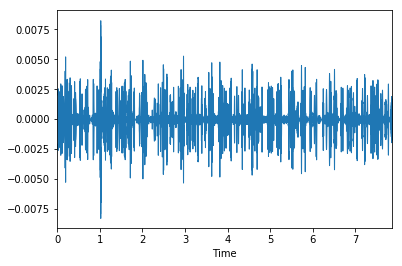

In [11]:
waveplot(ans, sr)

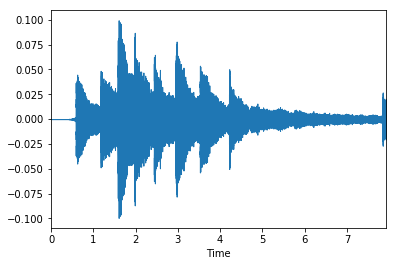

In [25]:
waveplot(ans, sr)

In [18]:
X.shape

(341, 1024, 128)

In [28]:
print(ans)

[0.         0.         0.         ... 0.0124409  0.01920281 0.02014092]


In [27]:
rr = [[1,2],[3,4],[5,6]]
B = []
B.extend(rr)
B[1]

[3, 4]

In [28]:
X

array([[[ 0.00000000e+00+0.0000000e+00j,  0.00000000e+00+0.0000000e+00j,
          0.00000000e+00+0.0000000e+00j, ...,
         -6.90312730e-03+0.0000000e+00j,  2.87001431e-02+0.0000000e+00j,
          1.49466857e-01+0.0000000e+00j],
        [ 0.00000000e+00+0.0000000e+00j,  0.00000000e+00+0.0000000e+00j,
          0.00000000e+00+0.0000000e+00j, ...,
          1.77159403e-02-4.3430823e-04j, -1.59279909e-02+3.5510767e-02j,
         -4.52934913e-02+8.4350735e-02j],
        [ 0.00000000e+00-0.0000000e+00j,  0.00000000e+00-0.0000000e+00j,
          0.00000000e+00-0.0000000e+00j, ...,
         -1.73118971e-02+9.2996489e-03j,  3.02878371e-03-2.3090495e-02j,
         -7.29393214e-02+4.7391155e-03j],
        ...,
        [ 0.00000000e+00+0.0000000e+00j,  0.00000000e+00+0.0000000e+00j,
          0.00000000e+00+0.0000000e+00j, ...,
         -1.28261890e-04-1.8711382e-05j,  1.46490484e-05-4.1601194e-05j,
          5.03309246e-04+5.8999825e-03j],
        [ 0.00000000e+00+0.0000000e+00j,  0.0000000

In [0]:
B, _ = librosa.load('./tracks/A_h3kt6Dp9M', sr = sr)

In [0]:
rr = istft(stft(B[8*sr:16*sr]))

In [36]:
ipd.Audio(data = rr, rate = sr)